In [1]:
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import multiprocessing
import jieba


In [2]:
# Load the datasets

df_gemini = pd.read_csv("results_data/experimental_design_results_gemini-2.0-flash-thinking-exp_reprocessed.csv")
df_gemini['model'] = 'Gemini-2FTE' # gemini-2.0-flash-thinking-exp

df_deepseek = pd.read_csv("results_data/experimental_design_results_deepseek-chat.csv")
df_deepseek['model'] = 'DeepSeek-V3' # deepseek-chat v3

df_gpt = pd.read_csv("results_data/experimental_design_results_gpt-4.5-preview-2025-02-27.csv")
df_gpt['model'] = 'OpenAI-GPT-4.5' # gpt-4.5-preview-2025-02-27

df_grok = pd.read_csv("results_data/experimental_design_results_grok-beta.csv")
df_grok['model'] = 'Grok-Beta' # grok-beta

df_sonnet = pd.read_csv("results_data/experimental_design_results_claude-3-7-sonnet-20250219.csv")
df_sonnet['model'] = 'Claude-Sonnet-3.7' # claude-3-7-sonnet-20250219

# Stack data frames
df = pd.concat([df_gemini, df_deepseek, df_gpt, df_grok, df_sonnet], ignore_index=True)

# Print
print(df)


                                               abstract  Repetition  \
0     文章首先阐述了工程教育专业认证与应用化学专业生产实习课程的关联，然后论述了工程教育专业认证背...           1   
1     文章首先阐述了工程教育专业认证与应用化学专业生产实习课程的关联，然后论述了工程教育专业认证背...           2   
2     文章首先阐述了工程教育专业认证与应用化学专业生产实习课程的关联，然后论述了工程教育专业认证背...           3   
3     “天然药物化学”是高等学校药学及相关专业的必修课程。课程章节内容多、理论性强,学生学习面临较...           1   
4     “天然药物化学”是高等学校药学及相关专业的必修课程。课程章节内容多、理论性强,学生学习面临较...           2   
...                                                 ...         ...   
1330  <正>化学作为一门自然科学，是人们认识世界和改造世界的重要途径。在历史长河中，化学是经由无数...           2   
1331  <正>化学作为一门自然科学，是人们认识世界和改造世界的重要途径。在历史长河中，化学是经由无数...           3   
1332  绿色化学分析技术，即最大限度地减少或者避免有害化学品被应用于分析过程当中，从而实现环境保护与...           1   
1333  绿色化学分析技术，即最大限度地减少或者避免有害化学品被应用于分析过程当中，从而实现环境保护与...           2   
1334  绿色化学分析技术，即最大限度地减少或者避免有害化学品被应用于分析过程当中，从而实现环境保护与...           3   

                                                  ZH_EN  \
0     The article first elaborates on the connection...   
1     The article first elabo

In [3]:
# Tokenization function for Chinese texts using Jieba
def tokenize_chinese_jieba(text):
    # Use Jieba to cut the Chinese text into words
    return list(jieba.cut(text))

# Function to calculate BLEU (using unigram and bigram)
def calculate_bleu(candidate_tokens, reference_tokens, weights=(0.5, 0.5, 0.0, 0.0)):
    # We use weights (0.5, 0.5) for unigrams and bigrams
    try:
        return sentence_bleu([reference_tokens], candidate_tokens, weights=weights)
    except Exception as e:
        return 0

# Function to calculate CHRF (character n-gram F-score)
def calculate_chrf(candidate_tokens, reference_tokens):
    candidate_str = "".join(candidate_tokens)
    reference_str = "".join(reference_tokens)
    # Calculates the ratio between the intersection and the union of the characters of the reference
    return len(set(candidate_str) & set(reference_str)) / len(set(reference_str)) if len(set(reference_str)) > 0 else 0

# Function to calculate TER using TF-IDF vectorization and mean squared error
def calculate_ter(candidate_text, reference_text):
    vectorizer = TfidfVectorizer() #token_pattern=r"(?u)\b\w+\b" - Removed token pattern because it is not needed for chinese
    try:
        tfidf_matrix = vectorizer.fit_transform([candidate_text, reference_text])
        return mean_squared_error(tfidf_matrix[0].toarray(), tfidf_matrix[1].toarray())
    except Exception as e:
        return 0

# Function to calculate Semantic Similarity (TF-IDF + cosine)
def calculate_semantic_similarity(original, translated):
    vectorizer = TfidfVectorizer() #token_pattern=r"(?u)\b\w+\b" - Removed token pattern because it is not needed for chinese
    try:
        tfidf_matrix = vectorizer.fit_transform([original, translated])
        return cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    except Exception as e:
        return 0

# Apply metrics to each row of the DataFrame
def calculate_metrics_for_row(row):
    original_text = row['abstract']
    back_translation = row['EN_ZH']

    # Tokenize the texts using Jieba
    original_tokens = tokenize_chinese_jieba(original_text)
    translated_tokens = tokenize_chinese_jieba(back_translation)

    # Calculate the metrics:
    bleu_value = calculate_bleu(translated_tokens, original_tokens)
    chrf_value = calculate_chrf(translated_tokens, original_tokens)
    ter_value = calculate_ter("".join(translated_tokens), "".join(original_tokens))
    semantic_similarity = calculate_semantic_similarity(original_text, back_translation)
    bleu_value_uniform = calculate_bleu(translated_tokens, original_tokens, weights=(0.25, 0.25, 0.25, 0.25))

    return pd.Series([bleu_value, bleu_value_uniform, chrf_value, ter_value, semantic_similarity])

def calculate_metrics_for_df(df):
    # tqdm.pandas(desc="Calculating metrics") # Removed progress bar
    return df.apply(calculate_metrics_for_row, axis=1)

def apply_parallel(df, func, n_cores=multiprocessing.cpu_count()):
    df_split = np.array_split(df, n_cores)
    pool = multiprocessing.Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

df[['BLEU', 'BLEU-Unif', 'CHRF', 'TER', 'Semantic Sim']] = apply_parallel(df, calculate_metrics_for_df)

/mnt/4d4f90e5-f220-481e-8701-f0a546491c35/arquivos/projetos/bt-conference/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading mod

In [4]:
# Display the results:
df_complete = df.copy()
print(df[['model', 'EN_ZH', 'BLEU', 'BLEU-Unif', 'CHRF', 'TER', 'Semantic Sim']])


                  model                                              EN_ZH  \
0           Gemini-2FTE  文章首先阐述了工程教育专业认证与应用化学专业生产实习课程之间的联系。接着，探讨了在工程教育专...   
1           Gemini-2FTE  文章首先阐述了工程教育专业认证与应用化学专业生产实习课程之间的关系。其次，探讨了在工程教育专...   
2           Gemini-2FTE  文章首先阐述工程教育专业认证与应用化学生产实习课程的关系。然后探讨工程教育专业认证背景下应用...   
3           Gemini-2FTE  天然产物化学是高等院校药学及相关专业的必修课。课程内容章节丰富且理论性强，学生在学习中面临诸...   
4           Gemini-2FTE  天然药物化学是高校药学及相关专业的必修课。该课程内容广泛且理论性强，对学生的学习造成挑战。因...   
...                 ...                                                ...   
1330  Claude-Sonnet-3.7  化学作为一门自然科学，是人们认识和改造世界的重要方式。纵观历史进程，化学通过无数次实验探索逐...   
1331  Claude-Sonnet-3.7  化学作为一门自然科学，是人们认识和改造世界的重要方式。纵观历史进程，化学是通过无数次实验探索...   
1332  Claude-Sonnet-3.7  绿色化学分析技术指的是在分析过程中最小化或避免使用有害化学物质，从而实现环境保护和可持续发展...   
1333  Claude-Sonnet-3.7  绿色化学分析技术旨在最小化或避免在分析过程中使用有害化学品，从而实现环境保护和可持续发展。文...   
1334  Claude-Sonnet-3.7  绿色化学分析技术旨在最小化或避免在分析过程中使用有害化学品，从而实现环境保护和可持续发展。文...   

          BLEU  BLEU-Unif      CHRF       TER  Semantic Sim  
0

In [5]:
# Global Descriptive Statistics
global_stats = df[['BLEU', 'BLEU-Unif', 'CHRF', 'TER', 'Semantic Sim']].describe()
print("\nGlobal Descriptive Statistics:")
print(global_stats.to_markdown())  # Output as markdown for journal

# Descriptive Statistics by Model
model_stats = df.groupby('model')[['BLEU', 'BLEU-Unif', 'CHRF', 'TER', 'Semantic Sim']].describe()

# Flatten the multi-level index for better readability in the table
model_stats.columns = [' '.join(col).strip() for col in model_stats.columns.values]

correlation_matrix = df[['BLEU', 'BLEU-Unif', 'CHRF', 'TER', 'Semantic Sim']].corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.to_markdown())

print("\nDescriptive Statistics by Model:")
print(model_stats.to_markdown()) # Output as markdown for journal


Global Descriptive Statistics:
|       |        BLEU |   BLEU-Unif |         CHRF |          TER |   Semantic Sim |
|:------|------------:|------------:|-------------:|-------------:|---------------:|
| count | 1335        | 1335        | 1335         | 1335         |   1335         |
| mean  |    0.569254 |    0.386816 |    0.837777  |    0.0816742 |      0.10539   |
| std   |    0.112392 |    0.133179 |    0.0620577 |    0.101293  |      0.102522  |
| min   |    0        |    0        |    0         |    0.013339  |      0         |
| 25%   |    0.494114 |    0.296929 |    0.803214  |    0.053176  |      0.0386913 |
| 50%   |    0.575586 |    0.385203 |    0.844444  |    0.0692514 |      0.0792653 |
| 75%   |    0.64965  |    0.477061 |    0.879475  |    0.0869565 |      0.135073  |
| max   |    0.930949 |    0.925391 |    0.96875   |    1         |      0.691046  |

Correlation Matrix:
|              |     BLEU |   BLEU-Unif |       CHRF |         TER |   Semantic Sim |
|:---------

In [6]:
df.to_csv("results_metrics/results_metrics.csv", index=False)
df.to_excel("results_metrics/results_metrics.xlsx", index=False)


                       BLEU  BLEU-Unif      CHRF       TER  Semantic Sim
model                                                                   
Claude-Sonnet-3.7  0.593466   0.413402  0.849358  0.081884      0.117223
DeepSeek-V3        0.603285   0.428336  0.849430  0.080846      0.128719
Gemini-2FTE        0.599710   0.424819  0.853033  0.080768      0.114355
Grok-Beta          0.522270   0.331117  0.812656  0.082456      0.078798
OpenAI-GPT-4.5     0.527541   0.336404  0.824409  0.082417      0.087853


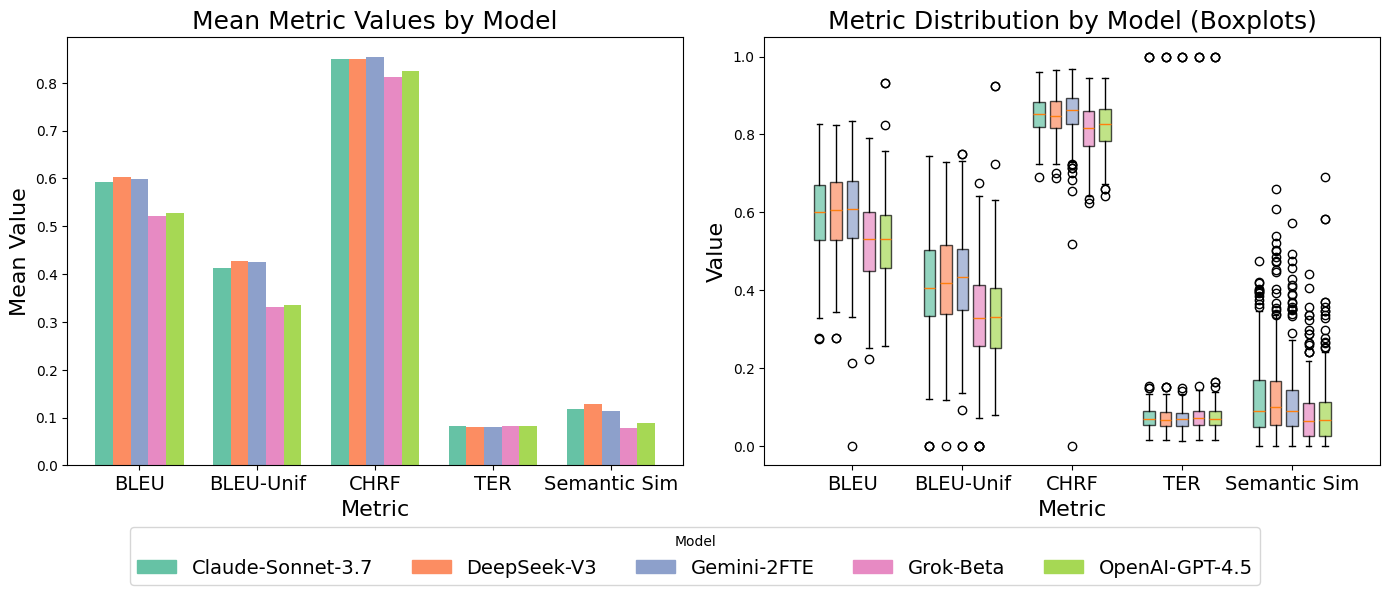

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import os

# Define the metrics
metrics = ['BLEU', 'BLEU-Unif', 'CHRF', 'TER', 'Semantic Sim']

# Calculate the mean of the metrics per model
model_means = df.groupby('model')[metrics].mean()
print(model_means)

# Ensure consistent model order
models = model_means.index.tolist()

# Define positions for the bar graphs
x = np.arange(len(metrics))
width = 0.15  # Bar width

# Define a more balanced color palette
colors = plt.get_cmap("Set2").colors[:len(models)]  # Set2 palette

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar graph (Mean metric values per model)
for i, model in enumerate(models):
    offset = (i - len(models) / 2 + 0.5) * width
    axes[0].bar(x + offset, model_means.loc[model], width, label=model, color=colors[i])

# Configuration of the first graph
axes[0].set_xlabel("Metric", fontsize=16)
axes[0].set_ylabel("Mean Value", fontsize=16)
axes[0].set_title("Mean Metric Values by Model", fontsize=18)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, fontsize=14)

# Prepare the data for the boxplots using the correct model order
data_for_boxplots = [[df[df['model'] == model][metric].values for model in models] for metric in metrics]

# Define positions for the boxplots
positions = []
for i in range(len(metrics)):
    positions.extend([i + (j - len(models) / 2 + 0.5) * width for j in range(len(models))])

# Flatten the data for the boxplot
flattened_data = [item for sublist in data_for_boxplots for item in sublist]

# Create the boxplots
bplot = axes[1].boxplot(flattened_data, positions=positions, widths=width * 0.7, patch_artist=True)

# Apply colors to the boxplots
for i, patch in enumerate(bplot["boxes"]):
    patch.set_facecolor(colors[i % len(models)])
    patch.set_alpha(0.7)  # Transparency
    patch.set_edgecolor("black")  # Black outline

# Configuration of the second graph
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics, fontsize=14)
axes[1].set_xlabel("Metric", fontsize=16)
axes[1].set_ylabel("Value", fontsize=16)
axes[1].set_title("Metric Distribution by Model (Boxplots)", fontsize=18)

# Create a single legend for both plots
handles = [mpatches.Patch(color=colors[i], label=models[i]) for i in range(len(models))]

fig.legend(handles=handles, title="Model", loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(models), fontsize=14)

# General layout adjustments
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to make space for the bottom legend

# Create directory to save the results
output_dir = "results_figures"
os.makedirs(output_dir, exist_ok=True)

# Save the figure
plt.savefig(f"{output_dir}/metrics_by_model_corrected.png", dpi=300)

# Display the graph
plt.show()


In [8]:
import pandas as pd
import numpy as np
import os

def find_outliers(df, metric, model):
    """
    Identifies outliers in a given metric for a specific model using the IQR method.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        metric (str): The name of the metric to analyze.
        model (str): The name of the model to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing only the outlier rows for the specified metric and model.
                       Returns an empty DataFrame if no outliers are found.
    """
    data = df[(df['model'] == model)][metric]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df['model'] == model) & ((df[metric] < lower_bound) | (df[metric] > upper_bound))]
    return outliers

# Create directory to save the results
output_dir = "results_metrics"
os.makedirs(output_dir, exist_ok=True)

# Example usage:
all_outliers = pd.DataFrame()
for metric in metrics:
    for model in models:
        outliers = find_outliers(df, metric, model)
        if not outliers.empty:
            all_outliers = pd.concat([all_outliers, outliers])

if all_outliers.empty:
    print("No outliers found for any metric and model combination.")
else:
    # Save all outliers combined to a CSV file
    output_path_csv = os.path.join(output_dir, "all_outliers.csv")
    all_outliers.to_csv(output_path_csv, index=False)
    print(f"All outliers combined saved to {output_path_csv}")

    # Save all outliers combined to an Excel file
    output_path_xlsx = os.path.join(output_dir, "all_outliers.xlsx")
    all_outliers.to_excel(output_path_xlsx, index=False)
    print(f"All outliers combined saved to {output_path_xlsx}")


All outliers combined saved to results_metrics/all_outliers.csv
All outliers combined saved to results_metrics/all_outliers.xlsx


In [9]:
import scipy.stats as ss
from statsmodels.sandbox.stats.multicomp import multipletests
import seaborn as sns

# Define the columns for analysis
columns = ['BLEU', 'BLEU-Unif', 'CHRF', 'TER', 'Semantic Sim']

# Calculate the Spearman correlation matrix
spearman_corr = df[columns].corr(method='spearman')
display(spearman_corr)

# Calculate p-values for Spearman correlation coefficients
p_values = np.zeros(spearman_corr.shape)
for i in range(len(columns)):
    for j in range(len(columns)):
        if i != j:
            _, p_values[i, j] = ss.spearmanr(df[columns[i]], df[columns[j]], nan_policy='omit')
        else:
            p_values[i, j] = np.nan  # Set diagonal p-values to NaN

# Adjust p-values using Benjamini-Hochberg correction
p_values_flat = p_values.flatten()
reject, p_values_corrected, _, _ = multipletests(p_values_flat[~np.isnan(p_values_flat)], method='fdr_bh')
p_values_corrected_matrix = np.zeros_like(p_values)
p_values_corrected_matrix[~np.isnan(p_values)] = p_values_corrected

# Create a mask for insignificant correlations (p > 0.05)
mask = p_values_corrected_matrix > 0.05

# Create a mask for the upper triangle
mask_upper = np.triu(np.ones_like(spearman_corr, dtype=bool))

# Prepare annotations: correlation value or asterisk for significance
annotations = np.empty_like(spearman_corr, dtype=object)
for i in range(spearman_corr.shape[0]):
    for j in range(spearman_corr.shape[1]):
        if mask[i, j] or mask_upper[i,j]:
            annotations[i, j] = ""  # Empty string if masked
        else:
            annotations[i, j] = f"{spearman_corr.iloc[i, j]:.2f}"
            if p_values_corrected_matrix[i, j] <= 0.05:
                annotations[i, j] += "*"  # Add asterisk if significant

# Create the scatter plot matrix with Seaborn's PairGrid
g = sns.PairGrid(df[columns])
g.map_lower(sns.scatterplot, color="black")  # Plot scatter plots in the lower triangle
g.map_diag(sns.histplot, color="lightgray")  # Plot histograms on the diagonal
g.map_upper(sns.kdeplot, cmap="Blues")       # Plot densities in the upper triangle

# Add correlation annotations to the plots
for i in range(len(columns)):
    for j in range(i+1, len(columns)):  # Only fill the upper triangle
        g.axes[i, j].annotate(f"Corr: {spearman_corr.iloc[i, j]:.2f}\n", 
                              xy=(0.5, 0.5), xycoords="axes fraction", ha="center", va="center", 
                              fontsize=12, color="gray")

# Adding the title
plt.subplots_adjust(top=0.9)  # Adjust the top value as needed
plt.suptitle('Pairwise scatter plot matrix with Spearman’s correlations and Benjamini-Hochberg correction.', fontsize=14)


# Save the figure
filename = 'results_figures/pairplot_spearman_correlation_matrix.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.close()

print(f"Spearman correlation pairplot saved to {filename}")


,BLEU,BLEU-Unif,CHRF,TER,Semantic Sim
BLEU,1.000000,0.975755,0.668326,0.003468,0.408823
BLEU-Unif,0.975755,1.000000,0.642316,-0.021563,0.451456
CHRF,0.668326,0.642316,1.000000,-0.002049,0.369678
TER,0.003468,-0.021563,-0.002049,1.000000,-0.373627
Semantic Sim,0.408823,0.451456,0.369678,-0.373627,1.000000


Spearman correlation pairplot saved to results_figures/pairplot_spearman_correlation_matrix.png


In [10]:
import scipy.stats as ss
from statsmodels.sandbox.stats.multicomp import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

# Define the columns for analysis
columns = ['BLEU', 'BLEU-Unif', 'CHRF', 'TER', 'Semantic Sim']

# Get unique models
models = df['model'].unique()

for model in models:
    print(f"Analyzing model: {model}")
    df_model = df[df['model'] == model]

    # Calculate the Spearman correlation matrix
    spearman_corr = df_model[columns].corr(method='spearman')
    display(spearman_corr)

    # Calculate p-values for Spearman correlation coefficients
    p_values = np.zeros(spearman_corr.shape)
    for i in range(len(columns)):
        for j in range(len(columns)):
            if i != j:
                _, p_values[i, j] = ss.spearmanr(df_model[columns[i]], df_model[columns[j]], nan_policy='omit')
            else:
                p_values[i, j] = np.nan  # Set diagonal p-values to NaN

    # Adjust p-values using Benjamini-Hochberg correction
    p_values_flat = p_values.flatten()
    reject, p_values_corrected, _, _ = multipletests(p_values_flat[~np.isnan(p_values_flat)], method='fdr_bh')
    p_values_corrected_matrix = np.zeros_like(p_values)
    p_values_corrected_matrix[~np.isnan(p_values)] = p_values_corrected

    # Create a mask for insignificant correlations (p > 0.05)
    mask = p_values_corrected_matrix > 0.05

    # Create a mask for the upper triangle
    mask_upper = np.triu(np.ones_like(spearman_corr, dtype=bool))

    # Prepare annotations: correlation value or asterisk for significance
    annotations = np.empty_like(spearman_corr, dtype=object)
    for i in range(spearman_corr.shape[0]):
        for j in range(spearman_corr.shape[1]):
            if mask[i, j] or mask_upper[i,j]:
                annotations[i, j] = ""  # Empty string if masked
            else:
                annotations[i, j] = f"{spearman_corr.iloc[i, j]:.2f}"
                if p_values_corrected_matrix[i, j] <= 0.05:
                    annotations[i, j] += "*"  # Add asterisk if significant

    # Create the scatter plot matrix with Seaborn's PairGrid
    g = sns.PairGrid(df_model[columns])
    g.map_lower(sns.scatterplot, color="black")  # Plot scatter plots in the lower triangle
    g.map_diag(sns.histplot, color="lightgray")  # Plot histograms on the diagonal
    g.map_upper(sns.kdeplot, cmap="Blues")       # Plot densities in the upper triangle

    # Add correlation annotations to the plots
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):  # Only fill the upper triangle
            g.axes[i, j].annotate(f"Corr: {spearman_corr.iloc[i, j]:.2f}\n", 
                                  xy=(0.5, 0.5), xycoords="axes fraction", ha="center", va="center", 
                                  fontsize=12, color="gray")

    # Adding the title
    plt.subplots_adjust(top=0.9)  # Adjust the top value as needed
    plt.suptitle(f'Pairwise scatter plot matrix with Spearman’s correlations and Benjamini-Hochberg correction for {model}.', fontsize=14)


    # Save the figure
    filename = f'results_figures/pairplot_spearman_correlation_matrix_{model}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Spearman correlation pairplot saved to {filename}")


Analyzing model: Gemini-2FTE


,BLEU,BLEU-Unif,CHRF,TER,Semantic Sim
BLEU,1.000000,0.976323,0.594116,-0.010148,0.387195
BLEU-Unif,0.976323,1.000000,0.598809,-0.038515,0.435952
CHRF,0.594116,0.598809,1.000000,-0.042917,0.349138
TER,-0.010148,-0.038515,-0.042917,1.000000,-0.367045
Semantic Sim,0.387195,0.435952,0.349138,-0.367045,1.000000


Spearman correlation pairplot saved to results_figures/pairplot_spearman_correlation_matrix_Gemini-2FTE.png
Analyzing model: DeepSeek-V3


,BLEU,BLEU-Unif,CHRF,TER,Semantic Sim
BLEU,1.000000,0.977821,0.659810,0.061741,0.430938
BLEU-Unif,0.977821,1.000000,0.620781,0.033288,0.470496
CHRF,0.659810,0.620781,1.000000,0.065125,0.383916
TER,0.061741,0.033288,0.065125,1.000000,-0.428393
Semantic Sim,0.430938,0.470496,0.383916,-0.428393,1.000000


Spearman correlation pairplot saved to results_figures/pairplot_spearman_correlation_matrix_DeepSeek-V3.png
Analyzing model: OpenAI-GPT-4.5


,BLEU,BLEU-Unif,CHRF,TER,Semantic Sim
BLEU,1.000000,0.967985,0.622289,0.049895,0.303079
BLEU-Unif,0.967985,1.000000,0.567654,0.033804,0.344297
CHRF,0.622289,0.567654,1.000000,-0.007580,0.341046
TER,0.049895,0.033804,-0.007580,1.000000,-0.362489
Semantic Sim,0.303079,0.344297,0.341046,-0.362489,1.000000


Spearman correlation pairplot saved to results_figures/pairplot_spearman_correlation_matrix_OpenAI-GPT-4.5.png
Analyzing model: Grok-Beta


,BLEU,BLEU-Unif,CHRF,TER,Semantic Sim
BLEU,1.000000,0.970009,0.701876,-0.045362,0.397293
BLEU-Unif,0.970009,1.000000,0.667796,-0.071793,0.432765
CHRF,0.701876,0.667796,1.000000,0.007512,0.303213
TER,-0.045362,-0.071793,0.007512,1.000000,-0.370817
Semantic Sim,0.397293,0.432765,0.303213,-0.370817,1.000000


Spearman correlation pairplot saved to results_figures/pairplot_spearman_correlation_matrix_Grok-Beta.png
Analyzing model: Claude-Sonnet-3.7


,BLEU,BLEU-Unif,CHRF,TER,Semantic Sim
BLEU,1.000000,0.967537,0.594961,0.012729,0.346773
BLEU-Unif,0.967537,1.000000,0.580777,-0.024400,0.407031
CHRF,0.594961,0.580777,1.000000,0.003955,0.312869
TER,0.012729,-0.024400,0.003955,1.000000,-0.378915
Semantic Sim,0.346773,0.407031,0.312869,-0.378915,1.000000


Spearman correlation pairplot saved to results_figures/pairplot_spearman_correlation_matrix_Claude-Sonnet-3.7.png


In [11]:
from scipy.stats import shapiro

# Shapiro-Wilk Test for Normality
alpha = 0.05  # Significance level

for column in ['BLEU', 'BLEU-Unif', 'CHRF']:
    stat, p = shapiro(df[column])
    print(f"Shapiro-Wilk Test for {column}:")
    print(f"Statistic={stat:.3f}, p={p:.3f}")
    if p > alpha:
        print(f"{column} looks Gaussian (fail to reject H0)")
    else:
        print(f"{column} does not look Gaussian (reject H0)")
    print("\n")


Shapiro-Wilk Test for BLEU:
Statistic=0.994, p=0.000
BLEU does not look Gaussian (reject H0)


Shapiro-Wilk Test for BLEU-Unif:
Statistic=0.997, p=0.029
BLEU-Unif does not look Gaussian (reject H0)


Shapiro-Wilk Test for CHRF:
Statistic=0.899, p=0.000
CHRF does not look Gaussian (reject H0)




In [12]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multitest import multipletests  # For Benjamini-Hochberg correction

# List of metrics to be analyzed
metrics = ['BLEU', 'BLEU-Unif', 'CHRF', 'TER', 'Semantic Sim']

# Dictionary to store the results
results = {}

for metric in metrics:
    print(f"\n===== Analyzing {metric} =====")
    
    # Create matrix for Friedman test
    df_friedman = df_complete.pivot_table(index='abstract', columns='model', values=metric, aggfunc='mean')

    # Remove rows with null values (if a model was not applied to a text)
    df_friedman = df_friedman.dropna()

    # Apply Friedman test
    stat, p_value = friedmanchisquare(*df_friedman.values.T)

    # Save Friedman test result
    results[metric] = {"friedman_statistic": stat, "friedman_p_value": p_value}

    # If p-value is significant (p < 0.05), apply Dunn's test
    if p_value < 0.05:
        print(f"Significant difference detected for {metric} (p = {p_value:.5f}). Running Dunn's test...")

        # Dunn's test without multiple comparisons adjustment (will adjust later)
        dunn_results_raw = posthoc_dunn(df_complete, val_col=metric, group_col='model', p_adjust=None)

        # Apply Benjamini-Hochberg (BH) correction
        pvals = dunn_results_raw.values[np.triu_indices_from(dunn_results_raw, k=1)]  # Extract unique p-values
        _, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

        # Reconstruct the corrected p-value matrix
        dunn_results_corrected = dunn_results_raw.copy()
        idx = np.triu_indices_from(dunn_results_corrected, k=1)
        dunn_results_corrected.values[idx] = pvals_corrected
        dunn_results_corrected.values.T[idx] = pvals_corrected  # Fill symmetrically

        # Identify models with significant differences
        significant_pairs = []
        diff_magnitudes = []
        
        model_means = df_complete.groupby("model")[metric].mean()  # Metric mean by model
        
        for i in range(len(dunn_results_corrected.index)):
            for j in range(i + 1, len(dunn_results_corrected.columns)):
                if dunn_results_corrected.iloc[i, j] < 0.05:
                    model1 = dunn_results_corrected.index[i]
                    model2 = dunn_results_corrected.columns[j]
                    mean_diff = abs(model_means[model1] - model_means[model2])  # Absolute difference of means
                    significant_pairs.append((model1, model2))
                    diff_magnitudes.append((model1, model2, mean_diff))

        results[metric]["dunn_results"] = dunn_results_corrected
        results[metric]["significant_pairs"] = significant_pairs
        results[metric]["mean_differences"] = diff_magnitudes
    else:
        print(f"No significant differences detected for {metric} (p = {p_value:.5f}).")
        results[metric]["dunn_results"] = None
        results[metric]["significant_pairs"] = []
        results[metric]["mean_differences"] = []

# Display final results
print("\n===== Final Results =====")
for metric, res in results.items():
    print(f"\nMetric: {metric}")
    print(f"  Friedman Test Statistic: {res['friedman_statistic']:.3f}")
    print(f"  Friedman Test p-value: {res['friedman_p_value']:.5f}")

    if res["dunn_results"] is not None:
        print("  Significant differences found. Dunn's test results available.")
        if res["significant_pairs"]:
            print("  Models with significant differences and mean differences:")
            for pair in res["mean_differences"]:
                print(f"    - {pair[0]} vs {pair[1]} | Mean Difference: {pair[2]:.4f}")
        else:
            print("  No significant pairwise differences detected.")
    else:
        print("  No significant differences found.")



===== Analyzing BLEU =====
Significant difference detected for BLEU (p = 0.00000). Running Dunn's test...

===== Analyzing BLEU-Unif =====
Significant difference detected for BLEU-Unif (p = 0.00000). Running Dunn's test...

===== Analyzing CHRF =====
Significant difference detected for CHRF (p = 0.00000). Running Dunn's test...

===== Analyzing TER =====
Significant difference detected for TER (p = 0.00000). Running Dunn's test...

===== Analyzing Semantic Sim =====
Significant difference detected for Semantic Sim (p = 0.00000). Running Dunn's test...

===== Final Results =====

Metric: BLEU
  Friedman Test Statistic: 152.476
  Friedman Test p-value: 0.00000
  Significant differences found. Dunn's test results available.
  Models with significant differences and mean differences:
    - Claude-Sonnet-3.7 vs Grok-Beta | Mean Difference: 0.0712
    - Claude-Sonnet-3.7 vs OpenAI-GPT-4.5 | Mean Difference: 0.0659
    - DeepSeek-V3 vs Grok-Beta | Mean Difference: 0.0810
    - DeepSeek-V3 vs

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, entropy

# Load relevant data
df_tmp2 = df_complete[['BLEU', 'BLEU-Unif', 'CHRF', 'TER']].dropna()

metrics_to_analyze = {
    'BLEU': ['CHRF', 'TER'],
    'BLEU-Unif': ['CHRF', 'TER']
}

print("\n=== Probabilistic Independence Test ===")

threshold = 0.05  # Small KL divergence suggests near-independence

for base_metric, comparison_metrics in metrics_to_analyze.items():
    # 1. Estimate Marginal PDFs using Gaussian Kernel Density Estimation (KDE)
    base_pdf = gaussian_kde(df_tmp2[base_metric])
    
    # Generate evaluation points for base metric
    x_base = np.linspace(df_tmp2[base_metric].min(), df_tmp2[base_metric].max(), 100)
    
    # Compute Marginal Probabilities for base metric
    p_base = base_pdf(x_base)

    for comparison_metric in comparison_metrics:
        # Estimate Marginal PDF for comparison metric
        comparison_pdf = gaussian_kde(df_tmp2[comparison_metric])
        
        # Generate evaluation points for comparison metric
        x_comparison = np.linspace(df_tmp2[comparison_metric].min(), df_tmp2[comparison_metric].max(), 100)
        
        # Compute Marginal Probabilities for comparison metric
        p_comparison = comparison_pdf(x_comparison)

        # 2. Estimate Joint PDF
        joint_pdf = gaussian_kde(np.vstack([df_tmp2[base_metric], df_tmp2[comparison_metric]]))

        # Evaluate joint probabilities
        xx_base, yy_comparison = np.meshgrid(x_base, x_comparison)
        p_joint = joint_pdf(np.vstack([xx_base.ravel(), yy_comparison.ravel()])).reshape(xx_base.shape)

        # 3. Compute Expected Joint Probability under Independence Assumption
        p_expected = np.outer(p_base, p_comparison)

        # 4. Compare using KL-Divergence (Relative Entropy)
        kl_div = entropy(p_joint.ravel(), p_expected.ravel())

        print(f"KL Divergence ({base_metric} vs. {comparison_metric}): {kl_div:.4f}")

        # Interpretation
        if kl_div < threshold:
            print(f"Conclusion: {comparison_metric} is approximately independent of {base_metric}.")
        else:
            print(f"Conclusion: {comparison_metric} is dependent on {base_metric}.")



=== Probabilistic Independence Test ===
KL Divergence (BLEU vs. CHRF): 13.2658
Conclusion: CHRF is dependent on BLEU.
KL Divergence (BLEU vs. TER): 102.8610
Conclusion: TER is dependent on BLEU.
KL Divergence (BLEU-Unif vs. CHRF): 55.7010
Conclusion: CHRF is dependent on BLEU-Unif.
KL Divergence (BLEU-Unif vs. TER): 69.2557
Conclusion: TER is dependent on BLEU-Unif.


In [14]:
import pyoverleaf as po

api = po.Api()
api.login_from_browser()
project_id_1 = "67d9c8fe7f24ec29473d5b73" # rascunho
project_id_2 = "67d179aff40b55ddef667a6c" # (Li)

for project_id in [project_id_1, project_id_2]:
    root_folder = api.project_get_files(project_id).children
    figures_folder_id = next(file.id for file in root_folder if file.name == "Figures")

    figures_dir = "results_figures"
    for filename in os.listdir(figures_dir):
        if filename.endswith(".png"):
            filepath = os.path.join(figures_dir, filename)
            try:
                file_bytes = open(filepath, "rb").read()
                new_file = api.project_upload_file(project_id, figures_folder_id, filename, file_bytes)
                print(f"Uploaded {filename} to project {project_id} successfully.")
            except Exception as e:
                print(f"Error uploading {filename} to project {project_id}: {e}")


Uploaded pairplot_spearman_correlation_matrix_DeepSeek-V3.png to project 67d9c8fe7f24ec29473d5b73 successfully.
Uploaded metrics_by_model_corrected.png to project 67d9c8fe7f24ec29473d5b73 successfully.
Uploaded pairplot_spearman_correlation_matrix_Claude-Sonnet-3.7.png to project 67d9c8fe7f24ec29473d5b73 successfully.
Uploaded pairplot_spearman_correlation_matrix_OpenAI-GPT-4.5.png to project 67d9c8fe7f24ec29473d5b73 successfully.
Uploaded pairplot_spearman_correlation_matrix_Grok-Beta.png to project 67d9c8fe7f24ec29473d5b73 successfully.
Uploaded pairplot_spearman_correlation_matrix_Gemini-2FTE.png to project 67d9c8fe7f24ec29473d5b73 successfully.
Uploaded pairplot_spearman_correlation_matrix.png to project 67d9c8fe7f24ec29473d5b73 successfully.
Uploaded pairplot_spearman_correlation_matrix_DeepSeek-V3.png to project 67d179aff40b55ddef667a6c successfully.
Uploaded metrics_by_model_corrected.png to project 67d179aff40b55ddef667a6c successfully.
Uploaded pairplot_spearman_correlation_ma